In [1]:
import xarray as xr
import pandas as pd

In [4]:
ZARR_PATH = "/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_2.zarr"

## Load from Zarr

In [5]:
ds_from_zarr = xr.open_dataset(ZARR_PATH, mode="r", engine="zarr")

In [6]:
ds_from_zarr

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 16008, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2016-03-22T15:00:00 ... 2021-10-16T...
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 -183000 -181000 -179000 ... 1219000 1221000 1223000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 ...

Variables perhaps to avoid:

hcct?  Looks like a static map of the UK?

False


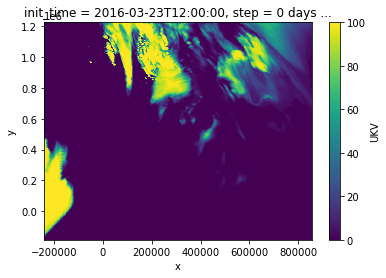

In [22]:
VARIABLE = "hcc"

print(ds_from_zarr['UKV'].sel(variable=VARIABLE).isel(step=0, init_time=7).isnull().any().values)

ds_from_zarr['UKV'].sel(variable=VARIABLE).isel(step=0, init_time=7).plot.imshow()

In [8]:
ds_from_zarr['UKV'].encoding

{'chunks': (17, 1, 1, 352, 274),
 'preferred_chunks': {'variable': 17,
  'init_time': 1,
  'step': 1,
  'y': 352,
  'x': 274},
 'compressor': Blosc(cname='zstd', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [23]:
from nowcasting_dataset.data_sources import NWPDataSource

In [24]:
nwp_ds = NWPDataSource(history_minutes=60, forecast_minutes=120, channels=['t'], zarr_path=ZARR_PATH, image_size_pixels=64)

In [25]:
nwp_ds.open()

NWP y axis runs from bottom-to-top.  Will reverse y axis so it runs top-to-bottom.
/home/jack/miniconda3/envs/nowcasting_dataset/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
NWP Zarr has 6 duplicated init_times.  Fixing...
NWP Zarr init_time is not monotonic_increasing.  Fixing...


In [26]:
nwp_ds._data

,Array,Chunk
Bytes,850.28 GiB,5.89 MiB
Shape,"(1, 15990, 37, 704, 548)","(1, 2, 2, 704, 548)"
Count,1672552 Tasks,152019 Chunks
Type,float32,numpy.ndarray


In [27]:
from nowcasting_dataset.utils import remove_regex_pattern_from_keys

In [28]:
remove_regex_pattern_from_keys({'nwp_channels': ['t']}, "^nwp_")

{'channels': ['t']}